In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json

In [2]:
df = pd.read_csv('../data/movies_metadata.csv')
df.isna().sum()

/var/folders/rt/q1nqm7vd4j175p7gyf5tqnhh0000gn/T/ipykernel_1204/3194182012.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/movies_metadata.csv')


adult                        0
belongs_to_collection    40972
budget                       0
genres                       0
homepage                 37684
id                           0
imdb_id                     17
original_language           11
original_title               0
overview                   954
popularity                   5
poster_path                386
production_companies         3
production_countries         3
release_date                87
revenue                      6
runtime                    263
spoken_languages             6
status                      87
tagline                  25054
title                        6
video                        6
vote_average                 6
vote_count                   6
dtype: int64

Important fields:
- adult
- genres
- imdb_id
- original_language
- original_title
- overview
- release_date
- vote_average
- vote_count

In [3]:
features = ['adult', 'genres', 'imdb_id', 'original_language', 'original_title', 
            'overview', 'release_date', 'vote_average', 'vote_count']
df = df[features]
df.shape

(45466, 9)

In [4]:
df.isna().sum()

adult                  0
genres                 0
imdb_id               17
original_language     11
original_title         0
overview             954
release_date          87
vote_average           6
vote_count             6
dtype: int64

In [5]:
df.fillna('Unknown', inplace=True)

/var/folders/rt/q1nqm7vd4j175p7gyf5tqnhh0000gn/T/ipykernel_1204/2825310197.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Unknown' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.fillna('Unknown', inplace=True)


The generes column is of this form:

In [6]:
df['genres'][0]

"[{'id': 16, 'name': 'Animation'}, {'id': 35, 'name': 'Comedy'}, {'id': 10751, 'name': 'Family'}]"

And we would like to get all info: Animation, Comedy, Family. Here are sample codes:

In [7]:
genres_list = [{'id': 16, 'name': 'Animation'}, {'id': 35, 'name': 'Comedy'}, {'id': 10751, 'name': 'Family'}]
names = []
for genres in genres_list:
    name = genres['name']
    names.append(name)
separator = ', '
separator.join(names)

'Animation, Comedy, Family'

We will apply the method to the column genres. Note that genres from the column is string, and we need to:
- replace ' by " for the correct json format
- parse the string to python list with json.load()

In [8]:
def extract_genre_names(genres_str):
    genres_list = json.loads(genres_str.replace("'", '"'))
    names = []
    for genres in genres_list:
        name = genres['name']
        names.append(name)
    separator = ', '
    return separator.join(names)

In [9]:
df['genres'] = df['genres'].apply(extract_genre_names)

In [10]:
df['genres']

0         Animation, Comedy, Family
1        Adventure, Fantasy, Family
2                   Romance, Comedy
3            Comedy, Drama, Romance
4                            Comedy
                    ...            
45461                 Drama, Family
45462                         Drama
45463       Action, Drama, Thriller
45464                              
45465                              
Name: genres, Length: 45466, dtype: object

In [11]:
df.head()

,adult,genres,imdb_id,original_language,original_title,overview,release_date,vote_average,vote_count
0,False,"Animation, Comedy, Family",tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",1995-10-30,7.7,5415.0
1,False,"Adventure, Fantasy, Family",tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,1995-12-15,6.9,2413.0
2,False,"Romance, Comedy",tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,1995-12-22,6.5,92.0
3,False,"Comedy, Drama, Romance",tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",1995-12-22,6.1,34.0
4,False,Comedy,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,1995-02-10,5.7,173.0


In [12]:
df.isna().sum()

adult                0
genres               0
imdb_id              0
original_language    0
original_title       0
overview             0
release_date         0
vote_average         0
vote_count           0
dtype: int64

In [13]:
df['overview_length'] = df['overview'].apply(len)

<Axes: xlabel='overview_length', ylabel='Count'>

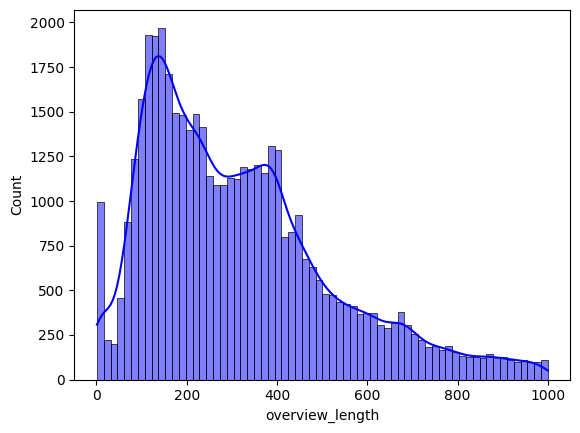

In [14]:
sns.histplot(
    data = df,
    x = 'overview_length',
    kde=True,
    color='blue'
)

The analysis indicates that the majority of movie overview texts contain between 100 and 400 words. We will import Sentence Transformer and transform overview to vectors.

In [15]:
from sentence_transformers import SentenceTransformer
from qdrant_client import models, QdrantClient
from qdrant_client.http.models import CollectionDescription, VectorParams

/Users/khanhdam/.local/share/virtualenvs/movie-recommendation-LLM-K7t7D6Dz/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
model = SentenceTransformer('all-MiniLM-L6-v2')
df['vectors'] = df['overview'].apply(lambda desc: model.encode(desc).tolist())

In [17]:
client = QdrantClient(host='localhost', port=6333)

In [19]:
client.recreate_collection(
    collection_name='movies',
    vectors_config=VectorParams(size=384, distance='Cosine')
)

True

In [20]:
df.columns

Index(['adult', 'genres', 'imdb_id', 'original_language', 'original_title',
       'overview', 'release_date', 'vote_average', 'vote_count',
       'overview_length', 'vectors'],
      dtype='object')

In [21]:
points=[]
for idx, row in df.iterrows():
    point = models.PointStruct(
        id = idx,
        vector = row['vectors'],
        payload = {
            "adult": row['adult'],
            "genres": row['genres'],
            "imdb_id": row['imdb_id'],
            "original_language": row['original_language'],
            "original_title": row['original_title'],
            "overview": row['overview'],
            "release_date": row['release_date'],
            "vote_average": row['vote_average'],
            "vote_count": row['vote_count']
        }
    )
    points.append(point)

In [22]:
client.upload_points(collection_name="movies", points=points)

We can now test the semantic search with an input query.

In [23]:
input_text = "I don't know"

In [24]:
results = []

In [25]:
hits = client.search(
    collection_name='movies',
    query_vector=model.encode(input_text).tolist(),
    limit = 3
)
for idx, hit in enumerate(hits):
    result = {}
    result['index'] = idx+1
    result['original_title'] = hit.payload['original_title']
    result['genres'] = hit.payload['genres']
    result['overview'] = hit.payload['overview']
    result['release_date'] = hit.payload['release_date']
    result['vote_average'] = hit.payload['vote_average']
    result['vote_count'] = hit.payload['vote_count']
    results.append(result)

In [26]:
results

[{'index': 1,
  'original_title': 'Happy Weekend',
  'genres': 'Comedy',
  'overview': 'Unknown',
  'release_date': '1996-03-14',
  'vote_average': 0.0,
  'vote_count': 0.0},
 {'index': 2,
  'original_title': 'Peanuts – Die Bank zahlt alles',
  'genres': 'Comedy',
  'overview': 'Unknown',
  'release_date': '1996-03-21',
  'vote_average': 4.0,
  'vote_count': 1.0},
 {'index': 3,
  'original_title': 'Roommates',
  'genres': 'Drama, Comedy',
  'overview': 'Unknown',
  'release_date': '1995-03-01',
  'vote_average': 6.4,
  'vote_count': 7.0}]

Here is an evaluation in the top 3 results:

- 'Viimne reliikvia' closely matches the Middle Ages theme but lacks traditional fantasy elements.
- 'The Ring Thing' offers a comedic take on the fantasy genre with a loose connection to the Middle Ages theme.
- 'Amazons' aligns with both the fantasy genre and the Middle Ages theme in a broader, mythical context.

As we can see, it is quite good. We can improve the results by implemeting an LLM layer to extract the genres and give more info for the input query.